In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd
import random
import time

pd.set_option('display.max_colwidth',1000)

%cd /content/drive/My Drive/Colab Notebooks/RS_Project

/content/drive/My Drive/Colab Notebooks/RS_Project


In [ ]:
anime = pd.read_csv('data/anime_info.csv')
anime.columns

## Crawl for Rating

In [ ]:
# Change this line for the user_id you wanna start with
last_revised_users = 0

with open("data/users.csv", "r", encoding="UTF-8") as file:
    file.readline()
    users = [x.strip().split(",") for x in file.readlines()]
    users = [(int(x[0]), x[1]) for x in users]

print(f'total user is {len(users)}, currently scraping user {last_revised_users}')


for i, (user_id, username) in enumerate(users):
    if user_id <= last_revised_users:
        continue

    print(f'\r{i+1}/{len(users)}', end="")
    page = 1
    all_animes = []

    while True:
        link = f"https://api.jikan.moe/v3/user/{username}/animelist/all?page={page}"
        try:
            time.sleep(4.2)
            data = requests.get(link, timeout=15)
        except KeyboardInterrupt:
            raise KeyboardInterrupt()
        except:  # Other exception wait 2 min and try again
            time.sleep(120)
            continue

        if data.status_code != 200:
            break

        data = json.loads(data.text)
        for anime in data["anime"]:
            all_animes.append((anime["mal_id"], anime["score"], anime["watching_status"], anime["watched_episodes"]))

        page += 1
        if len(data["anime"]) < 300:
            break

    if len(all_animes) != 0:
        with open(f"data/users/{user_id}.csv", "w") as f1:
            f1.write(f"anime_id,score,watching_status,watched_episodes\n")
            for anime_id, anime_score, watching_status, watched_episodes in all_animes:
                f1.write(
                    f"{anime_id},{anime_score},{watching_status},{watched_episodes}\n"
                )


In [ ]:
# find missing users (anime list inaccessible)
all_users = sorted(os.listdir('./data/users/'), key=lambda x:int(x.split(".")[0]))
missing_lst = []
for i in range(20000):
    if str(i)+'.csv' not in all_users:
        missing_lst.append(i)
print(f'missing user: {len(missing_lst)}')

In [ ]:
if not os.path.exists(f"data/animelist.csv"):
    with open(f"data/animelist.csv", "w", encoding="UTF-8") as file:
        file.write("user_id,anime_id,rating,watching_status,watched_episodes\n")
        
unique_anime = set(pd.read_csv('data/anime_info.csv')['MAL_ID'].unique())
all_users = sorted(os.listdir('./data/users/'), key=lambda x:int(x.split(".")[0]))

with open(f"data/animelist.csv", "a") as f1:

    for i, user_file in enumerate(all_users):
        if not user_file.endswith(".csv"):
            continue

        print(f"\r{i+1}/{len(all_users)}", end="")

        user_id = user_file.split(".")[0]
        with open(f"data/users/{user_file}", "r") as file:
            file.readline()
            for line in file:
                anime_id, score, watching_status, watched_episodes = line.strip().split(",")
                if int(anime_id) in unique_anime:
                    f1.write(f"{user_id},{anime_id},{score},{watching_status},{watched_episodes}\n")

## Crawl for pic url

In [ ]:
print(f'remaining {len(unique_anime)} animes require pic_url.')
lst = []
headers = {"User Agent": 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'}
for i in unique_anime:
    time.sleep(1+random.random())
    data = requests.get(f"https://myanimelist.net/anime/{i}")
    if data.reason != 'OK':
        time.sleep(60)
        data = requests.get(f"https://myanimelist.net/anime/{i}")
    anime_info = data.text
    soup = BeautifulSoup(anime_info, "html.parser")
    soup.script.decompose()
    link = soup.find_all('img')[1].get("data-src")
    lst.append((i,link))
    print(f'\r{len(lst)} record(s) collected',end='')
    if len(lst) % 50 == 1:
        if len(lst) == 1: # if it is a new list, clear the file content and write the column name
            with open("anime_pic_trial.csv", "w") as f1:
                f1.write('MAL_ID,pic_url,anime_url\n')

        # begin to write record to csv
        with open("anime_pic_trial.csv", "a") as f1:
            for item in lst[-50:]:
                f1.write(f"{item[0]},{item[1]},{'https://myanimelist.net/anime/'+str(item[0])}\n")
        print(' and write to file!',end='')
        
# pic = pd.read_csv('anime_pic.csv')
# print(f'file record {pic.shape[0]} records, adding {len(lst)} records')
# data = pd.DataFrame(lst,columns=['MAL_ID','pic_url'])
# data['anime_url'] = 'https://myanimelist.net/anime/' + data['MAL_ID'].astype(str)
# pic = pic.append(data).drop_duplicates()
# print(f'currently we have {pic.shape[0]} records.')
# pic.to_csv('anime_pic.csv',index=False)

## Rating data combined and rating plotting

In [ ]:
rating = pd.DataFrame()
for i in range(4):
    data = pd.read_csv(f'data/animelist_{i+1}.csv')
    rating = rating.append(data)

In [ ]:
df = rating.drop_duplicates()

In [ ]:
n_users = df.user_id.nunique()
n_items = df.anime_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 74706
Number of items: 16195
Number of available ratings: 27263752
Number of all possible ratings: 1209863670
----------------------------------------
SPARSITY: 97.75%


In [ ]:
item_rate_count = df.groupby("anime_id")["user_id"].nunique().sort_values(ascending=False)
item_rate_count.head(5)

anime_id
1535     56520
16498    56362
11757    53282
5114     49269
9253     48806
Name: user_id, dtype: int64

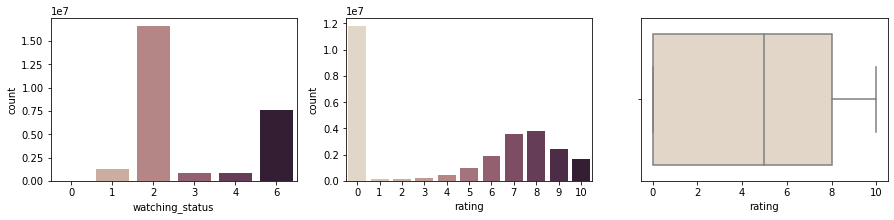

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.countplot(x='watching_status', data=df, palette="ch:.25", ax=axes[0])
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[1])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[2]);

In [ ]:
n_users = df[df['rating'] != 0].user_id.nunique()
n_items = df[df['rating'] != 0].anime_id.nunique()
n_ratings = len(df[df['rating'] != 0])
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 71971
Number of items: 15926
Number of available ratings: 15428111
Number of all possible ratings: 1146210146
----------------------------------------
SPARSITY: 98.65%


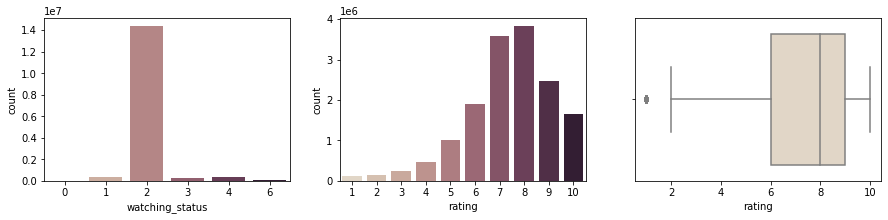

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
sns.countplot(x='watching_status', data=df[df['rating'] != 0], palette="ch:.25", ax=axes[0])
sns.countplot(x="rating", data=df[df['rating'] != 0], palette="ch:.25", ax=axes[1])
sns.boxplot(x="rating", data=df[df['rating'] != 0], palette="ch:.25", ax=axes[2]);

In [ ]:
df.to_csv('data/rating.csv',index=False)

In [ ]:
df[df['rating'] != 0].to_csv('data/rating_without_0.csv',index=False)

## Download Image from url

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/RS_Project/anime_pic
convert_table = anime[['MAL_ID','pic_url']].copy()
convert_table.drop(convert_table[convert_table['pic_url'].apply(type) == float].index).to_csv("anime_pic/try.csv",index=False)

/content/drive/My Drive/Colab Notebooks/RS_Project/anime_pic


In [ ]:
!source try.sh

## User info

In [ ]:
import os
import requests
import pandas as pd
import random
import time
import json

pd.set_option('display.max_colwidth',1000)

In [ ]:
last_users_id = 86983

timing_dic = {i:'.'*(i+1) for i in range(6)}
with open("data/users.csv", "r", encoding="UTF-8") as file:
    file.readline()
    users = [x.strip().split(",") for x in file.readlines()]
    users = [(int(x[0]), x[1]) for x in users]

print(f'total user is {len(users)}, start with user {last_users_id}')

for (user_id, username) in users:
    if user_id <= last_users_id:
        continue
    print(f"\rcrawling {user_id} users, username is {username}",end=timing_dic[user_id%6])
    time.sleep(4.2)
    data = requests.get(f"https://api.jikan.moe/v3/user/{username}/profile") 
    with open("data/user_profile.json","a") as f:   
        json.dump(json.loads(data.text),f)
        f.write('\n')
    print(f"\rcrawling {user_id} users, username is {username}",end='')

In [ ]:
test = pd.DataFrame()
with open('data/user_profile.json') as f:
    n = 1
    for line in f.readlines():
        print(f"\r{n}",end='')
        n += 1
        line = json.loads(line)
        test = test.append(pd.json_normalize(line))       
test.shape

In [ ]:
users = pd.read_csv('data/user_profile.csv')
user_profile = users[['username','last_online','gender','joined','anime_stats.days_watched','anime_stats.episodes_watched','manga_stats.days_read','manga_stats.chapters_read']].copy().drop_duplicates()
user_id = pd.read_csv('data/users.csv')
user_profile=user_profile.merge(user_id)

In [ ]:
user_profile['last_online_day'] = (pd.to_datetime('2021-07-10') - pd.to_datetime(user_profile['last_online'].str.slice(0,10))).dt.days
user_profile['joined_day'] = (pd.to_datetime('2021-07-10') - pd.to_datetime(user_profile['joined'].str.slice(0,10))).dt.days
user_profile['gender'] = user_profile['gender'].fillna('unknown')
user_profile = user_profile.fillna(0)
user_profile = user_profile.drop(columns=['username','last_online','joined'])
user_profile.loc[71986,'gender'] = 'unknown'
user_profile.loc[33472,'gender'] = 'Male'

In [ ]:
pd.get_dummies(data=user_profile, columns=['gender'],drop_first=True).to_csv('data/user_features.csv',index=False)